# Mine Production Planning with Stockpiling (with Pyomo)

## Introduction
Open-pit mine production scheduling is a central planning task in mining operations. The goal is to decide **when and how much material to extract and process** from different blocks of the mine, over a finite time horizon, in order to maximize the economic value of the project. Traditionally, this is formulated as the **Open Pit Mine Production Scheduling Problem (OPMPSP)**, which already is a large-scale mixed-integer optimization problem due to precedence constraints among blocks, mining and processing capacity limits, and economic discounting.

In practice, mining operations often make use of **stockpiles**: mined ore that is not immediately processed can be stored and reclaimed later. This flexibility allows the mine to adapt to fluctuations in ore quality and market conditions, increasing overall Net Present Value (NPV). However, the introduction of stockpiles complicates the optimization model: once material is placed into a stockpile, it is mixed homogeneously with existing material, and when it is reclaimed, the quality corresponds to the **average composition** of the stockpile. Mathematically, this leads to **bilinear (quadratic) constraints**, which are computationally challenging for standard MILP solvers.

The paper by [Bley, Boland, Froyland, and Zuckerberg (2012)](https://web.maths.unsw.edu.au/~froyland/bbfz.pdf) develops advanced formulations (Natural, Aggregated, and Discretized models) to handle stockpile effects within an optimization framework. Their results show that carefully designed extended formulations and branching strategies yield much tighter relaxations and practical solvability compared to naive models.


## Problem Description
We consider the **Open Pit Mine Production Scheduling Problem with Stockpiling (OPMPSP+S).**
The complete problem formulation and context are provided in the attached paper. 
Here, we focus on the implementation and include only brief explanatory comments.

In the paper, the model is presented in a general form without a concrete numerical example. In this notebook, we apply the model to the following practical case.

### Example

We consider a small mine with **5 blocks** to be scheduled over **3 time periods**. Each block is characterized by its rock tonnage, ore tonnage, and metal content, together with precedence constraints that specify the mining order. In each time period, mining and processing capacities limit how much material can be extracted and treated. In addition, a stockpile is available, allowing material to be stored for later processing, but subject to the homogeneous-mixing quality constraint.  

This small dataset allows us to illustrate the full model formulation, decision variables, and constraints in action, and to show how the optimization can be solved using `Pyomo`.


In [6]:
%load_ext autoreload
%autoreload 2

from pyomo.environ import ( 
    ConcreteModel, Set, Param, Var, Binary, NonNegativeReals, Reals,
    Constraint, Objective, maximize, summation, value, RangeSet
)
from pyomo.environ import SolverFactory

### Define data
Now, we define the data used in our example.

In [35]:
# interest rate
q = 0.10  

# scalar costs / global (time-invariant)
m = 2.0               # mining cost per tonne of rock
proc_cost = 5.0       # processing cost per tonne of ore
c = 100.0             # sales price per tonne of metal


# define discount factor for the profit made in time period t
def delta(t, q):
    """
    t: time period
    q: constant interest rate
    """
    return (1.0 / (1.0 + q) ** t)

# -- Time periods with mining and processing capacities --
# time_periods: {t: (mining_cap, processing_cap)}
time_data = {
    1: (15.0, 10.0),      # Period 1: 15 tonnes mining capacity, 10 tonnes processing capacity
    2: (15.0, 10.0),
    3: (15.0, 10.0)
}

# -- Blocks with (rock_tonnage R_i, ore_tonnage O_i, metal_tonnage A_i) --
# A_i corresponds to the contained metal if the entire block is processed.
blocks_data = {
    1: (10.0, 10.0, 8.0),       # Block 1: high grade (80% metal in ore)
    2: (10.0, 10.0, 6.0),       # Block 2: medium grade (60%)
    3: (15.0, 15.0, 4.5),       # Block 3: lower grade (30%)
    4: (10.0, 10.0, 5.0),       # Block 4: 50% grade
    5: ( 8.0,  8.0, 1.6)        # Block 5: low grade (20%)
}

# Define plants and stockpiles
plants = ['P']
stockpiles = ['S']

# Define waste dumps
waste_dumps = ['W']

# Precedence constraints: i can only advance after all j in P[i] are complete
P_pred = {    # predecessors of i
    3: {1, 2},
    4: {3}, 
    5: {3, 4}
}

### Visualising the problem

We can draw a directed graph with `graphviz` package to visulise the problem.

In [38]:
from graphviz import Digraph

def draw_problem(blocks_data = None, plants = None, stockpiles = None, waste_dumps = None):
    blocks_list = list(blocks_data.keys())
    plants_list = list(plants)
    stockpiles_list = list(stockpiles)
    waste_dumps_list = list(waste_dumps)

    dot = Digraph (
        graph_attr={'rankdir': 'TB', 'splines': 'ortho', 'newrank': 'true', 'size': '10,12', 'nodesep': '0.8', 'ranksep': '1.0'},
        node_attr={'fontsize': '12', 'fontname': 'Arial'},
        edge_attr={'color': 'gray', 'penwidth': '0.8'}
    )

    # === Nodes ===
    for i in blocks_list:
        dot.node(
            f"b{i}",
            label=f"Block {i}\nR={blocks_data[i][0]} O={blocks_data[i][1]} A={blocks_data[i][2]}",
            shape='box', fontcolor='blue'
        )

    for idx, s in enumerate(stockpiles_list, start=1):
        dot.node(
            f"s{s}",
            label=f"Stockpile {idx}\n",
            shape='doublecircle', fontcolor='blue'
        )

    for idx, w in enumerate(waste_dumps_list, start=1):
        dot.node(
            f"w{w}",
            label=f"Waste dump {idx}",
            shape='invhouse', fontcolor='blue'
        )

    for idx, p in enumerate(plants_list, start=1):
        dot.node(
            f"p{p}",
            label=f"Plant {idx}",
            shape='invhouse', fontcolor='blue'
        )

    # === Edges ===
    # Block -> Stockpile edges 
    for i in blocks_list:
        for s in stockpiles_list:
            dot.edge(f"b{i}", f"s{s}")
    
    # Block -> Waste dump edges 
    for i in blocks_list:
        for w in waste_dumps_list:
            dot.edge(f"b{i}", f"w{w}")
            
    # Block -> Plant edges 
    for i in blocks_list:
        for p in plants_list:
            dot.edge(f"b{i}", f"p{p}")
    # Stockpile -> Plant edges
    for s in stockpiles_list:
        for p in plants_list:
            dot.edge(f"s{s}", f"p{p}")
    # Stockpile -> Waste dump edges
    for s in stockpiles_list:
        for w in waste_dumps_list:
            dot.edge(f"s{s}", f"w{w}")
    return dot

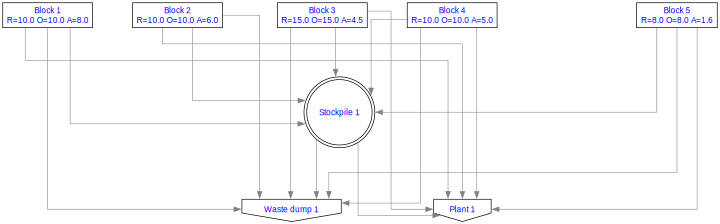

In [40]:
draw_problem(blocks_data=blocks_data, stockpiles=stockpiles, plants=plants, waste_dumps=waste_dumps)

### (1) Model Deployment (Natural Formulation $S_{[NF]}$)

We create a model and the variables. Solving quadratic assignment problems  with Gurobi is as easy as configuring the global parameter `nonConvex`, and setting this parameter to the value of 2.

In [43]:
def build_model():
    
    M = ConcreteModel()

    # ------ Sets ------
    M.T = Set(initialize=sorted(time_data.keys()), doc='time periods')
    M.I = Set(initialize=sorted(blocks_data.keys()), doc='blocks')
    M.P = Set(initialize=sorted(plants), doc='plants')
    M.S = Set(initialize=sorted(stockpiles), doc='stockpiles')    
    M.W = Set(initialize=sorted(waste_dumps), doc='waste dumps')
    M.Pred = Set(initialize=sorted(P_pred.keys()), doc='blocks with predecessors')
    

    # ------ Parameters ------

    
    # capacities
    M.mining_cap     = Param(M.T, initialize={t: time_data[t][0] for t in M.T}, within=Reals)
    M.processing_cap = Param(M.T, initialize={t: time_data[t][1] for t in M.T}, within=Reals)
    M.discount       = Param(M.T, initialize={t: delta(t, q) for t in M.T}, within=Reals)

    # block tonnages
    M.R = Param(M.I, initialize={i: blocks_data[i][0] for i in M.I}, within=Reals, doc='rock')
    M.O = Param(M.I, initialize={i: blocks_data[i][1] for i in M.I}, within=Reals, doc='ore')
    M.A = Param(M.I, initialize={i: blocks_data[i][2] for i in M.I}, within=Reals, doc='metal')

    # scalar economic params
    M.m_cost  = Param(initialize=m, doc='mining cost')
    M.p_cost  = Param(initialize=proc_cost, doc='processing cost')
    M.price_m = Param(initialize=c, doc='sales price of metal')

    # first and last period
    t0 = min(M.T)
    tT = max(M.T)
    

    # ------ Decision Variables ------ 

    
    # x[i,t] ∈ {0,1}: 1 if block i is completed (cumulative) by end of period t
    M.x = Var(M.I, M.T, domain=Binary) 

    # y[i,t] ∈ [0,1]: fraction of block i that is mined in period t
    M.y = Var(M.I, M.T, bounds=(0, 1))

    # z_p[i,t,p] ∈ [0,1]: fraction of block i sent directly to plant p in period t
    M.z_p = Var(M.I, M.T, M.P, bounds=(0, 1))

    # z_s[i,t,s] ∈ [0,1]: fraction of block i sent to stockpile s in period t
    M.z_s = Var(M.I, M.T, M.S, bounds=(0, 1))

    # oreSP[p,s,t] ≥ 0 : reclaimed ore flow from stockpile s to plant p in period t
    M.oreSP = Var(M.P, M.S, M.T, domain=NonNegativeReals)

    # oreS_rem[s,t] ≥ 0 : ore remaining in stockpile s at end of period t
    M.oreS_rem = Var(M.S, M.T, domain=NonNegativeReals)

    # metalSP[p,s,t] ≥ 0 : reclaimed metal flow (associated with oreSP) to plant
    M.metalSP = Var(M.P, M.S, M.T, domain=NonNegativeReals)

    # metalS_rem[s,t] ≥ 0 : metal content remaining in stockpile s at end of t
    M.metalS_rem = Var(M.S, M.T, domain=NonNegativeReals)



    # ------ Constraints ------


    # (1)  Cumulative completion: x[i,t-1] ≤ x[i,t]
    def cumulative_rule(M, i, t):
        if t == t0:
            return Constraint.Skip
        return M.x[i, t-1] <= M.x[i, t]
    M.Cumulative = Constraint(M.I, M.T, rule=cumulative_rule)

    # (2) Completion implies sufficient cumulative mining: x[i,t] ≤ sum_{τ ≤ t} y[i,τ]
    def link_xy_rule(M, i, t):
        return M.x[i, t] <= sum(M.y[i, tau] for tau in M.T if tau <= t)
    M.LinkXY = Constraint(M.I, M.T, rule=link_xy_rule)

    # (3) Each block mined at most once: sum_t y[i,t] ≤ 1
    def mined_once_rule(M, i):
        return sum(M.y[i, t] for t in M.T) <= 1.0
    M.MinedOnce = Constraint(M.I, rule=mined_once_rule)

    # (4) Precedence: for all i with predecessors j in P_pred[i],
    #     sum_{τ ≤ t} y[i,τ] ≤ x[j,t]  (i cannot advance ahead of j)
    def presedence_rule(M, i, j, t):
        # Apply only if i has predecessor j
        return sum(M.y[i, tau] for tau in M.T if tau <= t) <= M.x[j, t]
    # Build an index for (i, j, t) where j in P_pred[i]
    M.PrecedenceIndex = Set(initialize=[(i, j, t) for i in P_pred for j in P_pred[i] for t in M.T])
    M.Precedence = Constraint(M.PrecedenceIndex, rule=lambda M, i, j, t: presedence_rule(M, i, j, t))

    # (5) Splitting mined fraction into routing: sum_p z_p + sum_s z_s ≤ y[i,t]
    def split_rule(M, i, t):
        return (
            sum(M.z_p[i, t, p] for p in M.P)          # part sent tp plants
            + sum(M.z_s[i, t, s] for s in M.S)        # part sent to stockpiles
            <= M.y[i, t]                              # the summation cannot exceed mined fraction
        )
    M.SplitRouting = Constraint(M.I, M.T, rule=split_rule)

    # (6) Ore stockpile balance (for t > t0):
    #     oreS_rem[s,t-1] + sum_i O[i]*z_s[i,t-1,s] = oreS_rem[s,t] + sum_p oreSP[p,s,t]  
    def ore_balance_rule(M, s, t):
        if t == t0:
            return Constraint.Skip
        return (
            M.oreS_rem[s, t-1]
            + sum(M.O[i] * M.z_s[i, t-1, s] for i in M.I)
            == M.oreS_rem[s, t]
            + sum(M.oreSP[p, s, t] for p in M.P)
        )
    M.OreBalance = Constraint(M.S, M.T, rule=ore_balance_rule)

    # (7) Metal stockpile balance (for t > t0):
    #     metalS_rem[s,t-1] + sum_i A[i]*z_s[i,t-1,s] = metalS_rem[s,t] + sum_p metalSP[p,s,t]
    def metal_balance_rule(M, s, t):
        if t == t0:
            return Constraint.Skip
        return (
            M.metalS_rem[s, t-1]
            + sum(M.A[i] * M.z_s[i, t-1, s] for i in M.I)
            == M.metalS_rem[s, t]
            + sum(M.metalSP[p, s, t] for p in M.P)
        )
    M.MetalBalance = Constraint(M.S, M.T, rule=metal_balance_rule)

    # (8) Boundary conditions and no reclaim in period 1
    #     - Empty stockpile at start and end: oreS/metalS at t0 and tT are 0
    #     - No reclaim at t0: sum_p oreSP[p, s, t0] = sum_p metalSP[p, s, t0] = 0
    def ore_init_rule(M, s):  return M.oreS_rem[s, t0] == 0.0
    def ore_end_rule(M, s):   return M.oreS_rem[s, tT] == 0.0
    def metal_init_rule(M, s):  return M.metalS_rem[s, t0] == 0.0
    def metal_end_rule(M, s):   return M.metalS_rem[s, tT] == 0.0
    def no_reclaim_ore_t0_rule(M, s):   return sum(M.oreSP[p, s, t0] for p in M.P) == 0.0
    def no_reclaim_metal_t0_rule(M, s):   return sum(M.metalSP[p, s, t0] for p in M.P) == 0.0

    M.OreInit = Constraint(M.S, rule=ore_init_rule)
    M.OreEnd = Constraint(M.S, rule=ore_end_rule)
    M.MetalInit = Constraint(M.S, rule=metal_init_rule)
    M.MetalEnd  = Constraint(M.S, rule=metal_end_rule)
    M.NoReclaimOre_t0   = Constraint(M.S, rule=no_reclaim_ore_t0_rule)
    M.NoReclaimMetal_t0 = Constraint(M.S, rule=no_reclaim_metal_t0_rule)

    # (9) Mining capacity: sum_i R[i]*y[i,t] ≤ mining_cap[t]
    def mining_cap_rule(M, t):
        return (
            sum(M.R[i] * M.y[i, t] for i in M.I) <= M.mining_cap[t]
        )
    M.MiningCap = Constraint(M.T, rule=mining_cap_rule)

    # (10) Processing capacity: 
    #      sum_i O[i]*sum_p z_p[i,t,p] + sum_{p,s} oreSP[p,s,t] ≤ processing_cap[t]
    def processing_cap_rule(M, t):
        direct_ore = sum(M.O[i] * sum(M.z_p[i, t, p] for p in M.P) for i in M.I)
        reclaim_ore = sum(M.oreSP[p, s, t] for p in M.P for s in M.S)
        return direct_ore + reclaim_ore <= M.processing_cap[t]
    M.ProcessingCap = Constraint(M.T, rule=processing_cap_rule)

    # (11) Homogeneous-mixing ration constraint (nonconvex)
    #   For each t:
    #     aP_t * (oS_t + oP_t) == oP_t * (aS_t + aP_t)
    # where
    #   oP_t = sum_{p,s} oreSP[p,s,t],     aP_t = sum_{p,s} metalSP[p,s,t]
    #   oS_t = sum_s oreS_rem[s,t],        aS_t = sum_s metalS_rem[s,t]
    def mix_ratio_rule(M, t):
        aP_t = sum(M.metalSP[p, s, t] for p in M.P for s in M.S)
        aS_t = sum(M.metalS_rem[s, t] for s in M.S)
        oP_t = sum(M.oreSP[p, s, t] for p in M.P for s in M.S)
        oS_t = sum(M.oreS_rem[s, t] for s in M.S)
        return aP_t * (oP_t + oS_t) == oP_t * (aP_t + aS_t)
    M.MixRatio = Constraint(M.T, rule=mix_ratio_rule)
    


    # ------ Objective Function ------  


    
    # Profit in period t (discounted):
    #  price * (aP_t + direct_metal_t)
    #  - proc_cost * (oP_t + direct_ore_t)
    #  - mining_cost * mined_rock_t
    def period_terms(M, t):
        # reclaimed flows
        aP_t = sum(M.metalSP[p, s, t] for p in M.P for s in M.S)
        oP_t = sum(M.oreSP[p, s, t]   for p in M.P for s in M.S)
        # direct-to-plant flows from current mining
        dir_metal_t = sum(M.A[i] * sum(M.z_p[i, t, p] for p in M.P) for i in M.I)
        dir_ore_t   = sum(M.O[i] * sum(M.z_p[i, t, p] for p in M.P) for i in M.I)
        # mined rock in t
        mined_rock_t = sum(M.R[i] * M.y[i, t] for i in M.I)
        # discounted contribution
        return M.discount[t] * (M.price_m * (aP_t + dir_metal_t)
                               - M.p_cost * (oP_t + dir_ore_t)
                               - M.m_cost * (mined_rock_t))
    M.Obj = Objective(expr=sum(period_terms(M, t) for t in M.T), sense=maximize)


    #return M.Obj.pprint()
    return M

    
    

### Define Model

In [46]:
model = build_model()     # model building

model.write('models/MineProductionPlanning_NF_with_pyomo.lp')    # model saved

# Choose an solver to optimize
opt = SolverFactory("gurobi", solver_io="python")

# Match critical parameters
opt.options.update({
    "NonConvex": 2,      # required for bilinear / general nonconvex quadratic constraints
    "MIPGap": 1e-4,      
    "OutputFlag": 1,   # print solver log
})
results = opt.solve(model, tee=True)
print(results)
print("Objective value:", value(model.Obj))

Set parameter OutputFlag to value 1
Set parameter NonConvex to value 2
Set parameter MIPGap to value 0.0001
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2

Optimize a model with 76 rows, 72 columns and 241 nonzeros
Model fingerprint: 0x06c83ffc
Model has 3 quadratic constraints
Variable types: 57 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [4e+00, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 42 rows and 38 columns
Presolve time: 0.00s
Presolved: 43 rows, 37 columns, 119 nonzeros
Presolved model has 2 bilinear constraint(s)

So

### (2) Model Deployment (Mixed-Integer Linear Relaxation $S_{[NF-IP]}$)

We extend the NF model by relaxing its bilinear constraints(11).

In [49]:
def build_model():
    
    M = ConcreteModel()

    # ------ Sets ------
    M.T = Set(initialize=sorted(time_data.keys()), doc='time periods')
    M.I = Set(initialize=sorted(blocks_data.keys()), doc='blocks')
    M.P = Set(initialize=sorted(plants), doc='plants')
    M.S = Set(initialize=sorted(stockpiles), doc='stockpiles')    
    M.W = Set(initialize=sorted(waste_dumps), doc='waste dumps')
    M.Pred = Set(initialize=sorted(P_pred.keys()), doc='blocks with predecessors')
    

    # ------ Parameters ------

    
    # capacities
    M.mining_cap     = Param(M.T, initialize={t: time_data[t][0] for t in M.T}, within=Reals)
    M.processing_cap = Param(M.T, initialize={t: time_data[t][1] for t in M.T}, within=Reals)
    M.discount       = Param(M.T, initialize={t: delta(t, q) for t in M.T}, within=Reals)

    # block tonnages
    M.R = Param(M.I, initialize={i: blocks_data[i][0] for i in M.I}, within=Reals, doc='rock')
    M.O = Param(M.I, initialize={i: blocks_data[i][1] for i in M.I}, within=Reals, doc='ore')
    M.A = Param(M.I, initialize={i: blocks_data[i][2] for i in M.I}, within=Reals, doc='metal')

    # scalar economic params
    M.m_cost  = Param(initialize=m, doc='mining cost')
    M.p_cost  = Param(initialize=proc_cost, doc='processing cost')
    M.price_m = Param(initialize=c, doc='sales price of metal')

    # first and last period
    t0 = min(M.T)
    tT = max(M.T)
    

    # ------ Decision Variables ------ 

    
    # x[i,t] ∈ {0,1}: 1 if block i is completed (cumulative) by end of period t
    M.x = Var(M.I, M.T, domain=Binary) 

    # y[i,t] ∈ [0,1]: fraction of block i that is mined in period t
    M.y = Var(M.I, M.T, bounds=(0, 1))

    # z_p[i,t,p] ∈ [0,1]: fraction of block i sent directly to plant p in period t
    M.z_p = Var(M.I, M.T, M.P, bounds=(0, 1))

    # z_s[i,t,s] ∈ [0,1]: fraction of block i sent to stockpile s in period t
    M.z_s = Var(M.I, M.T, M.S, bounds=(0, 1))

    # oreSP[p,s,t] ≥ 0 : reclaimed ore flow from stockpile s to plant p in period t
    M.oreSP = Var(M.P, M.S, M.T, domain=NonNegativeReals)

    # oreS_rem[s,t] ≥ 0 : ore remaining in stockpile s at end of period t
    M.oreS_rem = Var(M.S, M.T, domain=NonNegativeReals)

    # metalSP[p,s,t] ≥ 0 : reclaimed metal flow (associated with oreSP) to plant
    M.metalSP = Var(M.P, M.S, M.T, domain=NonNegativeReals)

    # metalS_rem[s,t] ≥ 0 : metal content remaining in stockpile s at end of t
    M.metalS_rem = Var(M.S, M.T, domain=NonNegativeReals)



    # ------ Constraints ------


    # (1)  Cumulative completion: x[i,t-1] ≤ x[i,t]
    def cumulative_rule(M, i, t):
        if t == t0:
            return Constraint.Skip
        return M.x[i, t-1] <= M.x[i, t]
    M.Cumulative = Constraint(M.I, M.T, rule=cumulative_rule)

    # (2) Completion implies sufficient cumulative mining: x[i,t] ≤ sum_{τ ≤ t} y[i,τ]
    def link_xy_rule(M, i, t):
        return M.x[i, t] <= sum(M.y[i, tau] for tau in M.T if tau <= t)
    M.LinkXY = Constraint(M.I, M.T, rule=link_xy_rule)

    # (3) Each block mined at most once: sum_t y[i,t] ≤ 1
    def mined_once_rule(M, i):
        return sum(M.y[i, t] for t in M.T) <= 1.0
    M.MinedOnce = Constraint(M.I, rule=mined_once_rule)

    # (4) Precedence: for all i with predecessors j in P_pred[i],
    #     sum_{τ ≤ t} y[i,τ] ≤ x[j,t]  (i cannot advance ahead of j)
    def presedence_rule(M, i, j, t):
        # Apply only if i has predecessor j
        return sum(M.y[i, tau] for tau in M.T if tau <= t) <= M.x[j, t]
    # Build an index for (i, j, t) where j in P_pred[i]
    M.PrecedenceIndex = Set(initialize=[(i, j, t) for i in P_pred for j in P_pred[i] for t in M.T])
    M.Precedence = Constraint(M.PrecedenceIndex, rule=lambda M, i, j, t: presedence_rule(M, i, j, t))

    # (5) Splitting mined fraction into routing: sum_p z_p + sum_s z_s ≤ y[i,t]
    def split_rule(M, i, t):
        return (
            sum(M.z_p[i, t, p] for p in M.P)          # part sent tp plants
            + sum(M.z_s[i, t, s] for s in M.S)        # part sent to stockpiles
            <= M.y[i, t]                              # the summation cannot exceed mined fraction
        )
    M.SplitRouting = Constraint(M.I, M.T, rule=split_rule)

    # (6) Ore stockpile balance (for t > t0):
    #     oreS_rem[s,t-1] + sum_i O[i]*z_s[i,t-1,s] = oreS_rem[s,t] + sum_p oreSP[p,s,t]  
    def ore_balance_rule(M, s, t):
        if t == t0:
            return Constraint.Skip
        return (
            M.oreS_rem[s, t-1]
            + sum(M.O[i] * M.z_s[i, t-1, s] for i in M.I)
            == M.oreS_rem[s, t]
            + sum(M.oreSP[p, s, t] for p in M.P)
        )
    M.OreBalance = Constraint(M.S, M.T, rule=ore_balance_rule)

    # (7) Metal stockpile balance (for t > t0):
    #     metalS_rem[s,t-1] + sum_i A[i]*z_s[i,t-1,s] = metalS_rem[s,t] + sum_p metalSP[p,s,t]
    def metal_balance_rule(M, s, t):
        if t == t0:
            return Constraint.Skip
        return (
            M.metalS_rem[s, t-1]
            + sum(M.A[i] * M.z_s[i, t-1, s] for i in M.I)
            == M.metalS_rem[s, t]
            + sum(M.metalSP[p, s, t] for p in M.P)
        )
    M.MetalBalance = Constraint(M.S, M.T, rule=metal_balance_rule)

    # (8) Boundary conditions and no reclaim in period 1
    #     - Empty stockpile at start and end: oreS/metalS at t0 and tT are 0
    #     - No reclaim at t0: sum_p oreSP[p, s, t0] = sum_p metalSP[p, s, t0] = 0
    def ore_init_rule(M, s):  return M.oreS_rem[s, t0] == 0.0
    def ore_end_rule(M, s):   return M.oreS_rem[s, tT] == 0.0
    def metal_init_rule(M, s):  return M.metalS_rem[s, t0] == 0.0
    def metal_end_rule(M, s):   return M.metalS_rem[s, tT] == 0.0
    def no_reclaim_ore_t0_rule(M, s):   return sum(M.oreSP[p, s, t0] for p in M.P) == 0.0
    def no_reclaim_metal_t0_rule(M, s):   return sum(M.metalSP[p, s, t0] for p in M.P) == 0.0

    M.OreInit = Constraint(M.S, rule=ore_init_rule)
    M.OreEnd = Constraint(M.S, rule=ore_end_rule)
    M.MetalInit = Constraint(M.S, rule=metal_init_rule)
    M.MetalEnd  = Constraint(M.S, rule=metal_end_rule)
    M.NoReclaimOre_t0   = Constraint(M.S, rule=no_reclaim_ore_t0_rule)
    M.NoReclaimMetal_t0 = Constraint(M.S, rule=no_reclaim_metal_t0_rule)

    # (9) Mining capacity: sum_i R[i]*y[i,t] ≤ mining_cap[t]
    def mining_cap_rule(M, t):
        return (
            sum(M.R[i] * M.y[i, t] for i in M.I) <= M.mining_cap[t]
        )
    M.MiningCap = Constraint(M.T, rule=mining_cap_rule)

    # (10) Processing capacity: 
    #      sum_i O[i]*sum_p z_p[i,t,p] + sum_{p,s} oreSP[p,s,t] ≤ processing_cap[t]
    def processing_cap_rule(M, t):
        direct_ore = sum(M.O[i] * sum(M.z_p[i, t, p] for p in M.P) for i in M.I)
        reclaim_ore = sum(M.oreSP[p, s, t] for p in M.P for s in M.S)
        return direct_ore + reclaim_ore <= M.processing_cap[t]
    M.ProcessingCap = Constraint(M.T, rule=processing_cap_rule)

    # (11) Homogeneous-mixing ration constraint (nonconvex): is dropped!!
    


    # ------ Objective Function ------  


    
    # Profit in period t (discounted):
    #  price * (aP_t + direct_metal_t)
    #  - proc_cost * (oP_t + direct_ore_t)
    #  - mining_cost * mined_rock_t
    def period_terms(M, t):
        # reclaimed flows
        aP_t = sum(M.metalSP[p, s, t] for p in M.P for s in M.S)
        oP_t = sum(M.oreSP[p, s, t]   for p in M.P for s in M.S)
        # direct-to-plant flows from current mining
        dir_metal_t = sum(M.A[i] * sum(M.z_p[i, t, p] for p in M.P) for i in M.I)
        dir_ore_t   = sum(M.O[i] * sum(M.z_p[i, t, p] for p in M.P) for i in M.I)
        # mined rock in t
        mined_rock_t = sum(M.R[i] * M.y[i, t] for i in M.I)
        # discounted contribution
        return M.discount[t] * (M.price_m * (aP_t + dir_metal_t)
                               - M.p_cost * (oP_t + dir_ore_t)
                               - M.m_cost * (mined_rock_t))
    M.Obj = Objective(expr=sum(period_terms(M, t) for t in M.T), sense=maximize)


    #return M.Obj.pprint()
    return M

    
    

### Define Model

In [52]:
model = build_model()     # model building

model.write('models/MineProductionPlanning_NF_IP_with_pyomo.lp')    # model saved

# Choose an solver to optimize
opt = SolverFactory("gurobi", solver_io="python")

# Match critical parameters
opt.options.update({
    #"NonConvex": 2,      # required for bilinear / general nonconvex quadratic constraints: is dropped
    "MIPGap": 1e-4,      
    "OutputFlag": 1,   # print solver log
})
results = opt.solve(model, tee=True)
print(results)
print("Objective value:", value(model.Obj))

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.0001
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 76 rows, 72 columns and 241 nonzeros
Model fingerprint: 0xe474b39a
Variable types: 57 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [4e+00, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 43 rows and 40 columns
Presolve time: 0.00s
Presolved: 33 rows, 32 columns, 97 nonzeros
Variable types: 26 continuous, 6 integer (6 binary)

Root relaxation: objective 1.399850e+03, 18 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective

### (3) Model Deployment (Linear Relaxation $S_{[NF-LP]}$)

We extend the NF model by relaxing its bilinear constraints(11) and by dropping the integrality constraints from (NF)-version.

In [55]:
def build_model():
    
    M = ConcreteModel()

    # ------ Sets ------
    M.T = Set(initialize=sorted(time_data.keys()), doc='time periods')
    M.I = Set(initialize=sorted(blocks_data.keys()), doc='blocks')
    M.P = Set(initialize=sorted(plants), doc='plants')
    M.S = Set(initialize=sorted(stockpiles), doc='stockpiles')    
    M.W = Set(initialize=sorted(waste_dumps), doc='waste dumps')
    M.Pred = Set(initialize=sorted(P_pred.keys()), doc='blocks with predecessors')
    

    # ------ Parameters ------

    
    # capacities
    M.mining_cap     = Param(M.T, initialize={t: time_data[t][0] for t in M.T}, within=Reals)
    M.processing_cap = Param(M.T, initialize={t: time_data[t][1] for t in M.T}, within=Reals)
    M.discount       = Param(M.T, initialize={t: delta(t, q) for t in M.T}, within=Reals)

    # block tonnages
    M.R = Param(M.I, initialize={i: blocks_data[i][0] for i in M.I}, within=Reals, doc='rock')
    M.O = Param(M.I, initialize={i: blocks_data[i][1] for i in M.I}, within=Reals, doc='ore')
    M.A = Param(M.I, initialize={i: blocks_data[i][2] for i in M.I}, within=Reals, doc='metal')

    # scalar economic params
    M.m_cost  = Param(initialize=m, doc='mining cost')
    M.p_cost  = Param(initialize=proc_cost, doc='processing cost')
    M.price_m = Param(initialize=c, doc='sales price of metal')

    # first and last period
    t0 = min(M.T)
    tT = max(M.T)
    

    # ------ Decision Variables ------ 

    
    # x[i,t] ∈ {0,1}: 1 if block i is completed (cumulative) by end of period t
    M.x = Var(M.I, M.T, bounds=(0, 1))                                           # x[i,t] is converted into continuous variables!

    # y[i,t] ∈ [0,1]: fraction of block i that is mined in period t
    M.y = Var(M.I, M.T, bounds=(0, 1))

    # z_p[i,t,p] ∈ [0,1]: fraction of block i sent directly to plant p in period t
    M.z_p = Var(M.I, M.T, M.P, bounds=(0, 1))

    # z_s[i,t,s] ∈ [0,1]: fraction of block i sent to stockpile s in period t
    M.z_s = Var(M.I, M.T, M.S, bounds=(0, 1))

    # oreSP[p,s,t] ≥ 0 : reclaimed ore flow from stockpile s to plant p in period t
    M.oreSP = Var(M.P, M.S, M.T, domain=NonNegativeReals)

    # oreS_rem[s,t] ≥ 0 : ore remaining in stockpile s at end of period t
    M.oreS_rem = Var(M.S, M.T, domain=NonNegativeReals)

    # metalSP[p,s,t] ≥ 0 : reclaimed metal flow (associated with oreSP) to plant
    M.metalSP = Var(M.P, M.S, M.T, domain=NonNegativeReals)

    # metalS_rem[s,t] ≥ 0 : metal content remaining in stockpile s at end of t
    M.metalS_rem = Var(M.S, M.T, domain=NonNegativeReals)



    # ------ Constraints ------


    # (1)  Cumulative completion: x[i,t-1] ≤ x[i,t]
    def cumulative_rule(M, i, t):
        if t == t0:
            return Constraint.Skip
        return M.x[i, t-1] <= M.x[i, t]
    M.Cumulative = Constraint(M.I, M.T, rule=cumulative_rule)

    # (2) Completion implies sufficient cumulative mining: x[i,t] ≤ sum_{τ ≤ t} y[i,τ]
    def link_xy_rule(M, i, t):
        return M.x[i, t] <= sum(M.y[i, tau] for tau in M.T if tau <= t)
    M.LinkXY = Constraint(M.I, M.T, rule=link_xy_rule)

    # (3) Each block mined at most once: sum_t y[i,t] ≤ 1
    def mined_once_rule(M, i):
        return sum(M.y[i, t] for t in M.T) <= 1.0
    M.MinedOnce = Constraint(M.I, rule=mined_once_rule)

    # (4) Precedence: for all i with predecessors j in P_pred[i],
    #     sum_{τ ≤ t} y[i,τ] ≤ x[j,t]  (i cannot advance ahead of j)
    def presedence_rule(M, i, j, t):
        # Apply only if i has predecessor j
        return sum(M.y[i, tau] for tau in M.T if tau <= t) <= M.x[j, t]
    # Build an index for (i, j, t) where j in P_pred[i]
    M.PrecedenceIndex = Set(initialize=[(i, j, t) for i in P_pred for j in P_pred[i] for t in M.T])
    M.Precedence = Constraint(M.PrecedenceIndex, rule=lambda M, i, j, t: presedence_rule(M, i, j, t))

    # (5) Splitting mined fraction into routing: sum_p z_p + sum_s z_s ≤ y[i,t]
    def split_rule(M, i, t):
        return (
            sum(M.z_p[i, t, p] for p in M.P)          # part sent tp plants
            + sum(M.z_s[i, t, s] for s in M.S)        # part sent to stockpiles
            <= M.y[i, t]                              # the summation cannot exceed mined fraction
        )
    M.SplitRouting = Constraint(M.I, M.T, rule=split_rule)

    # (6) Ore stockpile balance (for t > t0):
    #     oreS_rem[s,t-1] + sum_i O[i]*z_s[i,t-1,s] = oreS_rem[s,t] + sum_p oreSP[p,s,t]  
    def ore_balance_rule(M, s, t):
        if t == t0:
            return Constraint.Skip
        return (
            M.oreS_rem[s, t-1]
            + sum(M.O[i] * M.z_s[i, t-1, s] for i in M.I)
            == M.oreS_rem[s, t]
            + sum(M.oreSP[p, s, t] for p in M.P)
        )
    M.OreBalance = Constraint(M.S, M.T, rule=ore_balance_rule)

    # (7) Metal stockpile balance (for t > t0):
    #     metalS_rem[s,t-1] + sum_i A[i]*z_s[i,t-1,s] = metalS_rem[s,t] + sum_p metalSP[p,s,t]
    def metal_balance_rule(M, s, t):
        if t == t0:
            return Constraint.Skip
        return (
            M.metalS_rem[s, t-1]
            + sum(M.A[i] * M.z_s[i, t-1, s] for i in M.I)
            == M.metalS_rem[s, t]
            + sum(M.metalSP[p, s, t] for p in M.P)
        )
    M.MetalBalance = Constraint(M.S, M.T, rule=metal_balance_rule)

    # (8) Boundary conditions and no reclaim in period 1
    #     - Empty stockpile at start and end: oreS/metalS at t0 and tT are 0
    #     - No reclaim at t0: sum_p oreSP[p, s, t0] = sum_p metalSP[p, s, t0] = 0
    def ore_init_rule(M, s):  return M.oreS_rem[s, t0] == 0.0
    def ore_end_rule(M, s):   return M.oreS_rem[s, tT] == 0.0
    def metal_init_rule(M, s):  return M.metalS_rem[s, t0] == 0.0
    def metal_end_rule(M, s):   return M.metalS_rem[s, tT] == 0.0
    def no_reclaim_ore_t0_rule(M, s):   return sum(M.oreSP[p, s, t0] for p in M.P) == 0.0
    def no_reclaim_metal_t0_rule(M, s):   return sum(M.metalSP[p, s, t0] for p in M.P) == 0.0

    M.OreInit = Constraint(M.S, rule=ore_init_rule)
    M.OreEnd = Constraint(M.S, rule=ore_end_rule)
    M.MetalInit = Constraint(M.S, rule=metal_init_rule)
    M.MetalEnd  = Constraint(M.S, rule=metal_end_rule)
    M.NoReclaimOre_t0   = Constraint(M.S, rule=no_reclaim_ore_t0_rule)
    M.NoReclaimMetal_t0 = Constraint(M.S, rule=no_reclaim_metal_t0_rule)

    # (9) Mining capacity: sum_i R[i]*y[i,t] ≤ mining_cap[t]
    def mining_cap_rule(M, t):
        return (
            sum(M.R[i] * M.y[i, t] for i in M.I) <= M.mining_cap[t]
        )
    M.MiningCap = Constraint(M.T, rule=mining_cap_rule)

    # (10) Processing capacity: 
    #      sum_i O[i]*sum_p z_p[i,t,p] + sum_{p,s} oreSP[p,s,t] ≤ processing_cap[t]
    def processing_cap_rule(M, t):
        direct_ore = sum(M.O[i] * sum(M.z_p[i, t, p] for p in M.P) for i in M.I)
        reclaim_ore = sum(M.oreSP[p, s, t] for p in M.P for s in M.S)
        return direct_ore + reclaim_ore <= M.processing_cap[t]
    M.ProcessingCap = Constraint(M.T, rule=processing_cap_rule)

    # (11) Homogeneous-mixing ration constraint (nonconvex): is dropped!!
    


    # ------ Objective Function ------  


    
    # Profit in period t (discounted):
    #  price * (aP_t + direct_metal_t)
    #  - proc_cost * (oP_t + direct_ore_t)
    #  - mining_cost * mined_rock_t
    def period_terms(M, t):
        # reclaimed flows
        aP_t = sum(M.metalSP[p, s, t] for p in M.P for s in M.S)
        oP_t = sum(M.oreSP[p, s, t]   for p in M.P for s in M.S)
        # direct-to-plant flows from current mining
        dir_metal_t = sum(M.A[i] * sum(M.z_p[i, t, p] for p in M.P) for i in M.I)
        dir_ore_t   = sum(M.O[i] * sum(M.z_p[i, t, p] for p in M.P) for i in M.I)
        # mined rock in t
        mined_rock_t = sum(M.R[i] * M.y[i, t] for i in M.I)
        # discounted contribution
        return M.discount[t] * (M.price_m * (aP_t + dir_metal_t)
                               - M.p_cost * (oP_t + dir_ore_t)
                               - M.m_cost * (mined_rock_t))
    M.Obj = Objective(expr=sum(period_terms(M, t) for t in M.T), sense=maximize)


    #return M.Obj.pprint()
    return M

    
    

### Define Model

In [58]:
model = build_model()     # model building

model.write('models/MineProductionPlanning_NF_LP_with_pyomo.lp')    # model saved

# Choose an solver to optimize
opt = SolverFactory("gurobi", solver_io="python")

# Match critical parameters
opt.options.update({
    #"NonConvex": 2,      # required for bilinear / general nonconvex quadratic constraints: is dropped
    "MIPGap": 1e-4,      
    "OutputFlag": 1,   # print solver log
})
results = opt.solve(model, tee=True)
print(results)
print("Objective value:", value(model.Obj))

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.0001
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 76 rows, 72 columns and 241 nonzeros
Model fingerprint: 0x9e7fe8f0
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [4e+00, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 19 rows and 23 columns
Presolve time: 0.01s
Presolved: 57 rows, 49 columns, 191 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9293511e+03   8.236517e+01   0.000000e+00      0s
      25    1.4148760e+03   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.414876033e+03

P